# 1: Import required libraries and initialization of global variables

In [1]:
#! pip install -r requirements.txt
#! pip install --force-reinstall -r requirements.txt

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import os
import glob
from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px
from ipywidgets import interact
from itertools import islice

from make_gif_from_folder import make_gif

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.set_device(0)
print(f'Selected devie is {device}')

BOUND_THRASHOLD = 0.3
PATH_TO_PM_DATA = './data/pm_format'
PATH_TO_MARKUP_DATA = './data/CL_23.txt'
PATH_TO_EPOCH_OUTS = './imgs/epoch_outs'
PATH_TO_TARGET0 = './imgs/target0/'
PATH_TO_TARGET = './imgs/target/'
PATH_TO_INPUT = './imgs/input/'

Selected devie is cuda:0


# 2: Neural network approach

## 2.1: Creating the model and dataset

#### 2.1.1: Dataset calss

In [2]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, path_to_file, mode, mode_3d, radius, reduce_fctor=1, need_help=False, need_info=False):
        self.need_help = need_help
        self.mode_3d = mode_3d
        self.radius = radius
        self.maps_markup = self.make_markup()
        self.pm_list = self.get_pm_list()
        self.reduce_factor = reduce_fctor
        if mode == 'img':
            self.map_number = ''
            self.img_array = self.get_img_array(path_to_file) 
        elif mode == 'abz':
            self.map_number = path_to_file[-11:-7]
            self.img_array, self.help_array = self.read_from_abz(path_to_file)
        else:
            self.map_number = ''
            self.img_array = path_to_file
        
        self.width, self.height = self.img_array.shape
        self.total_pixel = self.width * self.height

        self.bound_mask = np.where(self.img_array.reshape(-1, 1) < 255)[0]
        self.bound_length = len(np.where(self.img_array.reshape(-1, 1) < 255)[0])
        self.mask = np.where(self.img_array.reshape(-1, 1) == 255)[0]
        self.row_numbers = 1 * self.height
        # self.sign_mask = np.where((self._add_grad_label() * self.img_array).reshape(-1, 1) != 0)[0]

        self.data_2d, self.data_3d = self.make_data(mode_3d=self.mode_3d)
        self.data_3d.x, self.data_3d.y, self.data_3d.z = self.data_3d.T
        if need_info:
            print(f'width: {self.width}\n' +
                  f'height: {self.height}\n' +
                  f'total_pixel: {self.total_pixel}\n' +
                  f'bound length: {self.bound_length}\n' +
                  f'percent of bound pixels: {(100 * self.bound_length / self.total_pixel):.1f}%')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data_2d[idx], self.data_3d[idx]

    def get_img_array(self, path_to_file):
        return np.array(ImageOps.grayscale(Image.open(path_to_file))).astype(int)
        
    def get_pm_list(self):
        filenames = [filename for filename in glob.glob(f'{PATH_TO_PM_DATA}/*.dat')]
        pm_list = []
        for filename in filenames:
            with open(filename) as f:
                lines = [line[4:].replace('-1', '0').replace('+1', '1').rstrip() for line in f]
            pm_list.append(np.array([list(x) for x in lines], dtype = 'int'))
        return pm_list

    def _add_grad_label(self):
        tmp = self.img_array / self.img_array.max()

        left_shift, right_shift, up_shift, down_shift = np.ones((4, self.width, self.height))

        result = np.zeros(self.img_array.shape)

        left_shift[:, :-1] = tmp[:, 1:]
        right_shift[:, 1:] = tmp[:, :-1]
        up_shift[1:, :] = tmp[:-1, :]
        down_shift[:-1, :] = tmp[1:, :]

        result = left_shift + right_shift + down_shift + up_shift - 4 * tmp
        result = np.zeros(self.img_array.shape) != result
        return result.astype(int)

    def show_pm_list(self):
        plt.figure(figsize=(20, 30))
        maps_number = len(self.pm_list)
        for i in range(maps_number):
            plt.subplot(maps_number /  5, 5, i + 1) if maps_number % 5 == 0 else plt.subplot(maps_number // 5 + 1, 5, i + 1)
            plt.title(f'Map №{1904 + i}')
            plt.gca().axes.get_xaxis().set_visible(False)
            plt.gca().axes.get_yaxis().set_visible(False)
            plt.imshow(self.pm_list[i], cmap='gray')
        plt.show()
            
    def make_markup(self):
        res = {}
        current = 0
        with open(PATH_TO_MARKUP_DATA, 'r', encoding='windows-1251') as file:
            for line in file:
                try:
                    temp = list(map(int, line.rstrip().split()))
                except:
                    continue
                if len(temp) == 1:
                    current = temp[0]
                elif len(temp) == 0:
                    continue
                else:
                    if current not in res.keys():
                        res[current] = [temp[1:]] 
                    else:
                        res[current].append(temp[1:])
        return res
        
    def show_image(self):
        plt.figure(figsize=(10, 5))
        plt.title(f'Input Image №{self.map_number}')
        plt.imshow(self.img_array, cmap='gray', vmin=0, vmax=255)
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        width, height = my_shape[0], my_shape[1]
        img_array = np.full(shape=my_shape, fill_value=255)
        for line in lines[3:]:
            line = [int(x) for x in line.split()]
            if len(line) == 3:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
            elif len(line) == 5:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                x3 = line[3]
                x4 = -line[4]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
                for i in range(x3, x4 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
        if self.need_help:
            map_number = int(filename[-11:-7])
            i = 10
            help_array = np.full(shape=my_shape, fill_value=255)
            for line in self.maps_markup[map_number]:    
                for el in line:
                    x, y = int(el * (width - 1) / 180.), int(i * (height - 1) / 360.)
                    help_array[x, y] = 0
                    # help_array[min(x + 1, width - 1), y] = 0
                    # help_array[max(x - 1, 0), y] = 0
                    # help_array[x, min(y + 1, height - 1)] = 0
                    # help_array[x, max(y - 1, 0)] = 0
                i += 10
        return img_array, help_array if self.need_help else img_array

    def show_3d_static(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.data_3d.x, self.data_3d.y, self.data_3d.z, c=self.img_array.flatten())

    def show_3d(self):
        df = pd.DataFrame({'x': self.data_3d.x[::self.reduce_factor], 
                            'y': self.data_3d.y[::self.reduce_factor], 
                            'z': -self.data_3d.z[::self.reduce_factor], 
                            'label': self.img_array.flatten()[::self.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

    def make_data(self, mode_3d):
        data_2d = torch.from_numpy(np.stack(np.indices((self.width, self.height)), axis=2).reshape(-1, 2)).float()
        x, y = data_2d.T
        x -= x.mean()
        x /= x.abs().max()
        y -= y.mean()
        y /= y.abs().max()
        data_2d = torch.stack((x, y), dim=1)
        match mode_3d:
            case 'sphere':
                z = x
                x = torch.cos(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                y = torch.sin(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case 'cylinder':
                z = x
                x = torch.cos(torch.pi * y)
                y = torch.sin(torch.pi * y)
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case _:
                print('Incorrect mode\n')
                raise SystemError(f'Incorrect mode: {mode_3d}\n')
        return data_2d, data_3d

#### 2.1.2: Model class

In [3]:
class Net(nn.Module):
    __slots__ = 'dataset_list'
    def __init__(self, dataset_list, lr, weight_decay=1e-3):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 6), nn.ELU(),
            nn.Linear(6, 12), nn.ELU(),
            nn.Linear(12, 24), nn.ELU(),
            nn.Linear(24, 1), nn.Tanh())
        # self.weight = torch.nn.Parameter(torch.FloatTensor([1]), requires_grad=True)
        self.dataset_list = dataset_list
        self.data_list = [data.data_3d for data in self.dataset_list]
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)        
        self.loss_dict = {'loss': [],
                          'f_abs_integral': [],
                          'bound_integral': [],
                          'orientation_integral': [],
                          'f_integral': []}
                        #   'sign_integral': [],
                        #   'sign_integral_abs': []}
        
    def forward(self, x):
        #x = x.to(device)
        output = self.net(x)
        # res = output.clone()
        # output[res > BOUND_THRASHOLD] = 1
        # output[res > BOUND_THRASHOLD] = 1

        return output
    
    def compute_and_plot_gradient(self, input_list=None):
        batch_list = input_list if input_list is not None else self.data_list
        for batch in batch_list:
            batch.requires_grad_()
        tmp_list = [self(batch.to(device)) for batch in batch_list]
        for tmp in tmp_list:
            tmp.sum().backward()
        grad_out_list = [batch.grad.cpu() for batch in batch_list]
        grad_map_list = [((grad_out.pow(2).sum(dim=1)).pow(0.5)).view(dataset.img_array.shape) for grad_out, dataset in zip(grad_out_list, self.dataset_list)]
        plt.figure(figsize=(12, 6))
        for i, grad_map in enumerate(grad_map_list):
            plt.subplot(1, len(grad_map_list), i + 1)
            plt.title(r'Gradient map for $||\nabla f(x,y,z)||_2$' + f'\non input №{i + 1}', fontsize=15)
            plt.imshow(grad_map, cmap='plasma')
            plt.colorbar(location='bottom')
        return grad_out_list, grad_map_list

    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def show_loss_items(self):
        plt.figure(figsize=(16, 6))
        for i, (key, value) in islice(enumerate(self.loss_dict.items()), 1, len(self.loss_dict.keys())):
            plt.subplot(2, math.ceil((len(self.loss_dict.keys()) - 1) / 2), i)
            plt.xlabel('Epoch')
            plt.ylabel(key)
            plt.plot(value)  
        plt.show()

    def restart_model(self, lr, weight_decay=1e-3):
        model = Net(dataset_list=self.dataset_list, lr=lr, weight_decay=weight_decay)
        model.to(device)
        return model    

    def save_state_dict(self, path):
        torch.save(self.state_dict(), path)

    def show_3d(self, prediction_list, map_number):
        x, y, z = self.data_list[map_number].T
        df = pd.DataFrame({'x': x.cpu().detach().numpy(),
                            'y': y.cpu().detach().numpy(),
                            'z': -z.cpu().detach().numpy(),
                            'label': prediction_list[map_number].flatten()})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

    def test_model(self, input_list=None, need_plot=False):
        input_list = input_list if input_list is not None else self.data_list
        with torch.no_grad():
            output_list = [self(input.to(device)).cpu().detach() for input in input_list]
        if need_plot:
            plt.figure(figsize=(12, 6))
            for (i, output), data in zip(enumerate(output_list), self.dataset_list):
                plt.subplot(1, len(output_list), i + 1)
                plt.title(f'Visualization of the function $f(x,y,z)$\n on input №{i + 1}')
                plt.imshow(output.view(data.img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
        return output_list

    def start_training(self, num_epochs, my_weight=1e-1, show_frequency=1e+2, need_plot=False, need_save=True):
        if need_save:
            os.mkdir(PATH_TO_EPOCH_OUTS, exist_ok=True)

        for value in self.loss_dict.values():
            value.clear()

        batch_list = [data.to(device) for data in self.data_list]

        for epoch in range(1, int(num_epochs) + 1):
            output_list = [self(batch) for batch in batch_list]

            self.optimizer.zero_grad()
            loss = self.compute_loss(output_list=output_list, my_weight=my_weight) 
            loss.backward(retain_graph=True)
            self.optimizer.step()
            
            if need_plot and (epoch % int(show_frequency) == 0 or epoch == num_epochs):
                output_list = [output.cpu().detach().view(dataset.img_array.shape) for output, dataset in zip(output_list, self.dataset_list)]
                clear_output(wait=True)
                gs = gridspec.GridSpec(2, len(self.dataset_list) + 1)
                fig = plt.figure(figsize=(16, 6))
                
                ax1 = fig.add_subplot(gs[:, 0])
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.plot(self.loss_dict['loss'])

                for (i, img), data in zip(enumerate(output_list), self.dataset_list):
                    ax2 = fig.add_subplot(gs[0, i + 1])
                    ax2.title.set_text(f'Prediction №{i + 1}')
                    ax2.get_xaxis().set_ticks([])
                    ax2.get_yaxis().set_ticks([])
                    ax2.imshow(img, cmap='PuOr', vmin=-1, vmax=1)

                    ax3 = fig.add_subplot(gs[1, i + 1])
                    ax3.get_xaxis().set_ticks([])
                    ax3.get_yaxis().set_ticks([])
                    ax3.title.set_text(f'Input image №{i + 1}')
                    ax3.imshow(data.img_array, cmap='gray')
                self.show_loss_items()
                
                if need_save:
                    plt.savefig(PATH_TO_EPOCH_OUTS + '/epoch%06d.png' % epoch)
                plt.show()

    def compute_loss(self, output_list, my_weight): 
        loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(len(self.loss_dict.items())) #, sign_integral, sign_integral_abs = torch.zeros(7)
        loss_, f_abs_integral_, bound_integral_, orientation_integral_, f_integral_ = torch.zeros(len(self.loss_dict.items())) #, sign_integral_, sign_integral_abs_ = torch.zeros(7)

        for (output, dataset) in zip(output_list, self.dataset_list):
            output = output.flatten()
            upper_bound = (output[:dataset.row_numbers].sum() / len(output[:dataset.row_numbers]) - 1).abs()
            lower_bound = (output[-dataset.row_numbers:].sum() / len(output[-dataset.row_numbers:]) + 1).abs()

            for key, _ in self.loss_dict.items():
                locals()[key + "_"] = locals()[key].clone()

            # bound_length_integral  = bound_length_integral_ + len(torch.masked_select(output, ~output.abs().ge(0.5))) / len(output)
            f_integral = f_integral_ + my_weight * output.sum().abs() / dataset.total_pixel
            # sign_integral = sign_integral_ + output[dataset.sign_mask].sum().abs() / len(dataset.sign_mask)
            # sign_integral_abs = sign_integral_abs_ + 1 - output[dataset.sign_mask].abs().sum() / len(dataset.sign_mask)
            orientation_integral = orientation_integral_ + 0.25 * (upper_bound + lower_bound)
            f_abs_integral = f_abs_integral_ + 1 - output[dataset.mask].abs().sum() / (dataset.total_pixel - dataset.bound_length) # хочу НЕ границу +-1
            bound_integral = bound_integral_ + output[dataset.bound_mask].pow(2).sum() / dataset.bound_length # хочу на границе 0
            loss = loss_ + f_abs_integral + bound_integral + orientation_integral + f_integral# + 0.1 * (sign_integral + sign_integral_abs)

        for key, _ in self.loss_dict.items():
            self.loss_dict[key].append(locals()[key].item())
            
        return loss
        # w_bound = torch.sigmoid(self.weight)
        # w_abs = 1 - w_bound
        # return (w_abs + 1) * f_abs_integral + (w_bound + 1) * bound_integral + orientation_integral, w_bound

## 2.2: Training and testing the model on different datasets

### Single dataset list

#### Definition of the dataset list

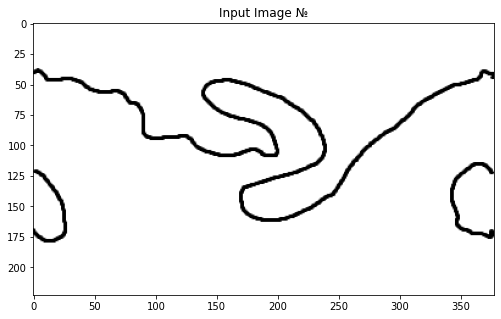

In [4]:
# dataset1=MyData(path_to_file='./data/sn1996k1906eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)
# dataset2=MyData(path_to_file='./data/sn1996k1907eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)
# dataset3=MyData(path_to_file='./data/sn1996k1908eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)

# dataset_list = [dataset1, dataset2, dataset3]
dataset1 = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
dataset2 = MyData(path_to_file='./imgs/2.png', mode='img', mode_3d='cylinder', radius=10, reduce_fctor=1, need_help=False)

dataset_list = [dataset1, dataset2]
dataset1.show_image()

#### Definition of the model

In [5]:
model = Net(dataset_list=dataset_list, lr=1e-3)
model.to(device)
# summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
# model.load_state_dict(torch.load('./3_cascade_1904.pt'))

Net(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=6, out_features=12, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=12, out_features=24, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=24, out_features=1, bias=True)
    (7): Tanh()
  )
)

#### Show start state

In [ ]:
prediction_list = model.test_model(need_plot=True)

In [ ]:
model.show_3d(prediction_list=prediction_list, map_number=1)

#### Training the model

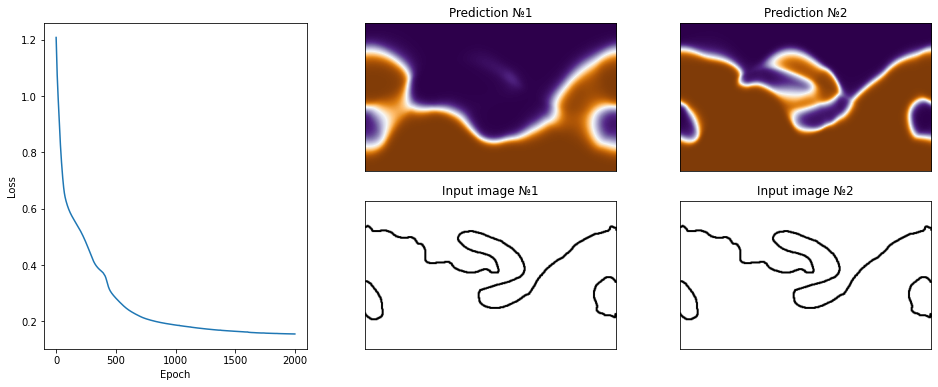

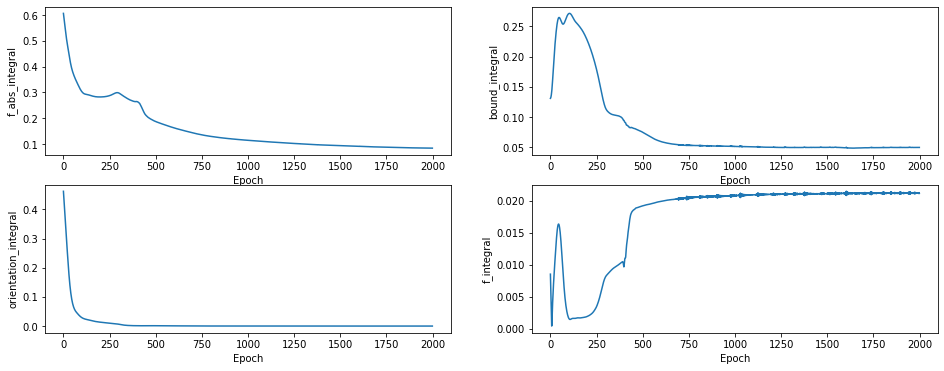

In [6]:
# model.change_lr(1e-3)
# model = model.restart_model(lr=1e-3)
model.start_training(num_epochs=2e+3, my_weight=0.1, need_save=False)
# model.show_loss_items()

In [ ]:
model.save_state_dict('')

In [ ]:
make_gif(dir_path='./epoch_outs', gifname='nice')

#### Testing the model

In [ ]:
prediction_list = model.test_model(model.data_list, need_plot=True)

In [ ]:
res
plt.imshow(res, cmap='PuOr')

In [ ]:
_, grad_map_list = model.compute_and_plot_gradient()

In [ ]:
model.show_3d(prediction_list=prediction_list, map_number=1)

In [ ]:
def test_model(self, input_list=None, need_plot=False):
    input_list = input_list if input_list is not None else self.data_list
    with torch.no_grad():
        output_list = [self(input.to(device)).cpu().detach() for input in input_list]
    if need_plot:
        plt.figure(figsize=(12, 6))
        for (i, output), data in zip(enumerate(output_list), self.dataset_list):
            plt.subplot(1, len(output_list), i + 1)
            plt.title(f'Visualization of the function $f(x,y,z)$\n on input №{i + 1}')
            plt.imshow(output.view(data.img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
    return output_list

### Map cascade

#### Get image

In [ ]:
dataset1 = MyData(path_to_file='./imgs/1904_low2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
# dataset2 = MyData(path_to_file='./data/sn1996k1905eng.abz', mode='abz', mode_3d='sphere', radius=2, reduce_fctor=1, need_help=False)

dataset_list = [dataset1] #, dataset2]

#### Definition of the function that downscales the map

In [5]:
def downscale_map(img_array, sq_size):
    width, height = img_array.shape
    tmp_arr = img_array.copy()
    if width % sq_size:
        tmp_arr = np.r_[img_array, np.zeros((sq_size - width % sq_size, height))]
        width, height = tmp_arr.shape
    if height % sq_size:
        tmp_arr = np.c_[tmp_arr, np.zeros((sq_size - height % sq_size, width)).T]
        width, height = tmp_arr.shape
    result = np.array([np.hsplit(u, height / sq_size) for u in np.vsplit(tmp_arr, width / sq_size)]).reshape((-1, sq_size, sq_size))
    final_result = np.array([x.sum() for x in result]).reshape((width // sq_size, height // sq_size)) == 0
    return final_result

#### Get map cascades from images

In [ ]:
normal_img_array_1 = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
map_cascade_1 = [downscale_map(normal_img_array_1, 2 ** x) for x in range(4, 0, -1)]

# convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
# map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

for cas_map in map_cascade_1:
    plt.imshow(cas_map, cmap = "gray")
    plt.show()

In [ ]:
normal_img_array_2 = 1 - np.array(dataset2.img_array, dtype='float64') / 255.
map_cascade_2 = [downscale_map(normal_img_array_2, 2 ** x) for x in range(7, 3, -1)]

# convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
# map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

for cas_map in map_cascade_2:
    plt.imshow(cas_map, cmap = "gray")
    plt.show()

####  Training the model

In [ ]:
# for i, cas_map in enumerate(zip(map_cascade_1, map_cascade_2)):
#     dataset1 = MyData(path_to_file=255 * cas_map[0], mode='2img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
#     dataset2 = MyData(path_to_file=255 * cas_map[1], mode='2img', mode_3d='cylinder', radius=2, reduce_fctor=1, need_help=False)

#     dataset_list = [dataset1, dataset2]
#     model = Net(dataset_list=dataset_list, lr=1e-3)
#     model.to(device)
#     # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
#     if i:
#         model.load_state_dict(torch.load(f'./state_dcit/{i - 1}_cascade_1904.pt'))
#     _ = model.test_model(model.data_list, need_plot=True)
#     # dataset1.show_image()
#     model.start_training(num_epochs=3e+3, my_weight=0.1)
#     model.show_loss_items()
#     model.save_state_dict(f'./state_dcit/{i}_cascade_1904.pt')
#     input()

for i, cas_map in enumerate(map_cascade_1):
    dataset1 = MyData(path_to_file=255 * cas_map, mode='2img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)

    dataset_list = [dataset1]
    model = Net(dataset_list=dataset_list, lr=1e-3)
    model.to(device)
    # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
    if i:
        model.load_state_dict(torch.load(f'./state_dict/{i}_cascade_1904.pt'))
    _ = model.test_model(model.data_list, need_plot=True)
    # dataset1.show_image()
    model.start_training(num_epochs=3e+3, my_weight=0.1)
    model.show_loss_items()
    model.save_state_dict(f'./state_dict/{i+1}_cascade_1904.pt')
    input()

### Research of range of $f(x,y,z)$


In [7]:
def make_data(mode_3d, radius):
    x, y = torch.from_numpy(np.stack(np.indices((200, 400)), axis=2).reshape(-1, 2)).float().T
    x -= x.mean()
    x /= x.abs().max()
    y -= y.mean()
    y /= y.abs().max()
    match mode_3d:
        case 'sphere':
            z = x
            x = torch.cos(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
            y = torch.sin(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
            data_3d = radius * torch.stack((x, y, z), dim=1)
        case 'cylinder':
            z = x
            x = torch.cos(torch.pi * y)
            y = torch.sin(torch.pi * y)
            data_3d = radius * torch.stack((x, y, z), dim=1)
        case _:
            print('Incorrect mode\n')
            raise SystemError(f'Incorrect mode: {mode_3d}\n')
    return data_3d

In [8]:
@interact(radius=(0, 20, 0.01), mode_3d=['cylinder', 'sphere'])
def my_homotopy(radius=1, mode_3d='cylinder'):
    batch_list = [make_data(mode_3d=mode_3d, radius=radius)]
    prediction_list = model.test_model(batch_list)
    for prediction in prediction_list:
        plt.figure(figsize=(12, 6))
        plt.title(f'Visualization of the function $f(x,y,z)$ on {mode_3d} with $r={radius}$')
        plt.imshow(prediction.view((200, 400)), cmap='PuOr', vmin=-1, vmax=1)

interactive(children=(FloatSlider(value=1.0, description='radius', max=20.0, step=0.01), Dropdown(description=…

## Big Test

### Map Cascade

#### Downscale visualization

In [6]:
def downscale_map(img_array, sq_size):
    width, height = img_array.shape
    tmp_arr = img_array.copy()
    if width % sq_size:
        tmp_arr = np.r_[img_array, np.zeros((sq_size - width % sq_size, height))]
        width, height = tmp_arr.shape
    if height % sq_size:
        tmp_arr = np.c_[tmp_arr, np.zeros((sq_size - height % sq_size, width)).T]
        width, height = tmp_arr.shape
    result = np.array([np.hsplit(u, height / sq_size) for u in np.vsplit(tmp_arr, width / sq_size)]).reshape((-1, sq_size, sq_size))
    final_result = np.array([x.sum() for x in result]).reshape((width // sq_size, height // sq_size)) == 0
    return final_result

@interact(path_to_file=glob.glob('./data/*.abz'))
def s_(path_to_file):
    dataset1 = MyData(path_to_file=path_to_file, mode='abz', mode_3d='cylinder', radius=10, reduce_fctor=1, need_help=False)
    normal_img_array_1 = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
    map_cascade_1 = [downscale_map(normal_img_array_1, sq_size=2 ** x) for x in [7, 6, 5, 3, 2]]

    # convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
    # map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

    for cas_map in map_cascade_1:
        plt.imshow(cas_map, cmap="gray")
        plt.title(f'{cas_map.shape}')
        plt.show()

interactive(children=(Dropdown(description='path_to_file', options=('./data\\sn1996k1904eng.abz', './data\\sn1…

#### Loop for training many models

In [48]:
def big_test(path_to_test='./BIG_TEST_MAP_CASCADE/'):
    for path_to_file in glob.glob('./data/*.abz'):
        filename = path_to_file.split('\\')[-1]
        cur_dir = path_to_test + filename[:-4]
        os.makedirs(cur_dir, exist_ok=True)
        
        for radius in [1., 2., 5., 10., 15., 20.]:
            cur_dir = path_to_test + filename[:-4] + f'/radius_{radius}'
            os.makedirs(cur_dir, exist_ok=True)

            dataset1 = MyData(path_to_file=path_to_file, mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
            dataset_list = [dataset1]
            normal_img_array = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
            map_cascade = [downscale_map(normal_img_array, sq_size=2**x) for x in [7, 6, 5, 3, 2]]
            
            for i, cas_map in enumerate(map_cascade):
                dataset1 = MyData(path_to_file=255 * cas_map, mode='2img', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)

                dataset_list = [dataset1]
                model = Net(dataset_list=dataset_list, lr=1e-3)
                model.to(device)
                # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))

                if i:
                    model.load_state_dict(torch.load(cur_dir+f'/{i}_state_dict.pt'))
                # _ = model.test_model(model.data_list, need_plot=True)
                # dataset1.show_image()
                model.start_training(num_epochs=5e+3, my_weight=0.1, need_plot=False, need_save=False)
                model.save_state_dict(cur_dir+f'/{i+1}_state_dict.pt')
        
# big_test()

#### Show results

In [ ]:
for map_name in os.listdir('./BIG_TEST_MAP_CASCADE/'):
    grid = plt.GridSpec(4, 3)
    plt.figure(figsize=(15, 15))
    # plt.suptitle(f'Visualization of the function $f(x,y,z)$ on {map_name}')

    for i, radius_path in enumerate(os.listdir(f'./BIG_TEST_MAP_CASCADE/{map_name}')):
        radius = float(radius_path.split('_')[-1])

        dataset = MyData(path_to_file=f'./data/{map_name}.abz', mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
        model=Net(dataset_list=[dataset], lr=1e-3).to(device)
        model.load_state_dict(torch.load(f'./BIG_TEST_MAP_CASCADE/{map_name}/{radius_path}/5_state_dict.pt'))
        with torch.no_grad():
            output_list = [model(input.to(device)).cpu().detach() for input in model.data_list]
            loss = model.compute_loss(output_list, my_weight=0.1)
        plt.subplot(grid[i // 3, i % 3])
        plt.imshow(output_list[0].view(dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
        plt.title(f'Radius = {radius}, Loss = {loss:.3f}')
    plt.subplot(grid[2, :])
    # plt.title(f'Target map {map_name}')
    path_to_target_img = f'./data/{map_name}.gif'
    plt.imshow(mpimg.imread(path_to_target_img), cmap='gray')
    plt.axis('off')
    plt.subplot(grid[3, :])
    plt.title(f'Original map {map_name}')
    plt.imshow(dataset.img_array, cmap='gray')
    
    os.makedirs('./BIG_TEST_MAP_CASCADE_results', exist_ok=True)
    plt.savefig(f'./BIG_TEST_MAP_CASCADE_results/{map_name}.png', facecolor='white')


#### Make table of results

In [69]:
res_dict = {}
for map_name in os.listdir('./BIG_TEST_MAP_CASCADE/'):
    res_dict[map_name] = {}
    for radius_path in os.listdir(f'./BIG_TEST_MAP_CASCADE/{map_name}'):
        radius = float(radius_path.split('_')[-1])
        dataset = MyData(path_to_file=f'./data/{map_name}.abz', mode='abz', mode_3d='cylinder', radius=radius, reduce_fctor=1, need_help=False)
        model=Net(dataset_list=[dataset], lr=1e-3).to(device)
        model.load_state_dict(torch.load(f'./BIG_TEST_MAP_CASCADE/{map_name}/{radius_path}/5_state_dict.pt'))
        with torch.no_grad():
            output_list = [model(input.to(device)).cpu().detach() for input in model.data_list]
            loss = model.compute_loss(output_list, my_weight=0.1)
        res_dict[map_name][radius] = loss.numpy()

In [70]:
df = pd.DataFrame.from_dict(res_dict, orient='index', columns=[1., 2., 5., 10., 15., 20.])
df

,1.0,2.0,5.0,10.0,15.0,20.0
sn1996k1904eng,0.17910649,0.13343988,0.16337517,0.12618695,0.1429933,0.21951117
sn1996k1905eng,0.3080644,0.30417284,0.17025696,0.24258286,0.1130567,0.08923017
sn1996k1906eng,0.18068337,0.11606892,0.19258796,0.09723622,0.17927095,0.0938478
sn1996k1907eng,0.23718216,0.37504908,0.2142726,0.3711627,0.2098669,0.19954531
sn1996k1908eng,0.13678554,0.15115261,0.07683112,0.08129287,0.6223429,0.078284696
sn1996k1909eng,0.114870355,0.25997916,0.25830814,0.13832031,0.2772987,0.09218259
sn1996k1910eng,0.7841412,0.7093341,0.16984908,0.16212864,0.16853276,0.16014926
sn1996k1911eng,0.21512854,0.17002791,0.17895973,0.13767628,0.21002138,0.724503
sn1996k1912eng,0.16261458,0.19972321,0.25447634,0.14700937,0.15166387,0.14492929
sn1996k1913eng,0.20427893,0.1648998,0.70845187,0.14818043,0.14949252,0.17160212


In [ ]:
def plot_df_by_rows(df):
    grid = plt.GridSpec(df.shape[0], 1)
    plt.figure(figsize=(10, 100))
    for i, row in enumerate(df.iterrows()):
        plt.subplot(grid[i, 0])
        plt.title(row[0])
        plt.plot(row[1].index, row[1].values)
        plt.xlabel('Radius')
        plt.ylabel('Loss')
    plt.show()
plot_df_by_rows(df)

# 3: Loss parameters optimization

## Neural network approach

### Preproccessing

#### Definition of the splitting map function

In [2]:
def split_map(path, x_parts, scale_coef, color, need_plot=False):

    img = np.array(ImageOps.grayscale(Image.open(path))).astype(int)
    width, height = img.shape
    
    if need_plot:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')

    y_parts = int(x_parts * height / width)
    dx = width // x_parts
    dy = height // y_parts
    delta = int(scale_coef * min(dx, dy) // 2)

    for x in range(dx // 2, width, dx):
        for y in range((1 + (x - dx // 2) // dx % 2) * dy // 2, height, dy):
        # for y in range(dy // 2, height, dy):
            img[x-delta:x+delta, y-delta:y+delta] = color
    
    if need_plot:
        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        print(f'width={width}\nheight={height}\nx_parts = {x_parts}\ny_parts = {y_parts}\ndelta = {delta}\ndx={dx}\ndy={dy}')
    return img

#### Split map interactively

In [11]:
@interact(path=glob.glob(PATH_TO_TARGET0+'*'), x_parts=(2, 10), scale_coef=(0.5, 1, 0.05), color=(150, 255))
def real_time_split(path=PATH_TO_TARGET0+'0001.png', x_parts=5, scale_coef=0.85, color=255):
    _ = split_map(path=path, x_parts=x_parts, scale_coef=scale_coef, color=color, need_plot=True)

interactive(children=(Dropdown(description='path', options=('./imgs/target0\\0001.png', './imgs/target0\\0002.…

#### 

In [ ]:
from color_script import get_result

for img_name in os.listdir(PATH_TO_TARGET0):
    _, ans = get_result(PATH_TO_TARGET0 + img_name)
    ans.save(PATH_TO_TARGET + img_name)
    
    img = split_map(path=PATH_TO_TARGET0 + img_name, x_parts=5, scale_coef=0.85, color=255,  need_plot=False)
    plt.imsave(PATH_TO_INPUT + img_name, img, cmap='gray')

## Graphical approach

### Dataset class

In [4]:
class InputImagesInfo(torch.utils.data.Dataset):
    def __init__(self, path_to_inputs, path_to_targets):
        self.info_dict = {'img_list': [],
                            'width_list': [],
                            'height_list': [],
                            'total_pixel_list': [],
                            'bound_length_list': [],
                            'mask_list': [],
                            'bound_mask_list': [],
                            'row_numbers_list': [],}
        for (input_path, target_path) in zip(path_to_inputs, path_to_targets):
            img = np.array(ImageOps.grayscale(Image.open(input_path))).astype(int)
            width, height = img.shape
            
            total_pixel = width * height
            bound_length = len(img.reshape(1, -1) < 255)
            mask = img.reshape(1, -1) == 255
            bound_mask = img.reshape(1, -1) < 255
            row_numbers = 1 * height
            
            img = np.array(ImageOps.grayscale(Image.open(target_path))).astype(int)
            img[img == 90] = -1
            img[img == 190] = 1
            img = torch.from_numpy(img)

            for key in self.info_dict.keys():
                self.info_dict[key].append(locals()[key[:-5]])

    def __len__(self):
        return len(self.info_dict['img_list'])

    def __getitem__(self, idx):
        return [value[idx] for value in self.info_dict.values()]

In [5]:
batch = InputImagesInfo(path_to_inputs=[PATH_TO_INPUT + '0001.png'],
                         path_to_targets=[PATH_TO_TARGET + '0001.png'])

1


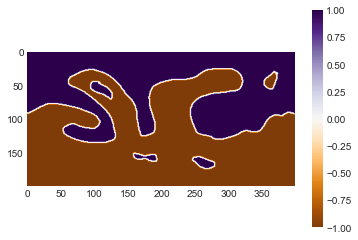

In [12]:
print(len(batch))
plt.imshow(batch[0][0], cmap='PuOr')
plt.colorbar()

### Calculating of the integrals in loss which are not dependent on the weights

In [12]:
loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(5)
integrals_dict = {'f_abs_integral': [],
                    'bound_integral': [],
                    'f_integral': []}

for img, width, height, total_pixel, bound_length, mask, bound_mask, row_numbers in batch:
    img = img.flatten()
    
    f_integral = img.sum().abs() / total_pixel
    f_abs_integral = 1 - img[mask].abs().sum() / (total_pixel - bound_length) # хочу НЕ границу +-1
    bound_integral = img[bound_mask].pow(2).sum() / bound_length # хочу на границе 0

    for key in integrals_dict.keys():
        integrals_dict[key].append(locals()[key])
        

In [13]:
integrals_dict

{'f_abs_integral': [tensor(0.0379)],
 'bound_integral': [tensor(0.)],
 'f_integral': [tensor(0.1589)]}

In [14]:
def compute_loss(weights_list): 
    f_integral_weight, f_abs_integral_weight, bound_integral_weight = weights_list
    # print(f_integral_weight, f_abs_integral_weight, bound_integral_weight)
    # f_abs_integral_weight = 0
    local_vars = locals()
    # print(locals()[key+'_weight'])
    res = sum([sum(local_vars[key+'_weight'] * np.array(integrals_dict[key])) for key in integrals_dict.keys()])
    return res
    # return f_integral_weight*sum(integrals_dict['f_integral']) + f_abs_integral_weight*sum(integrals_dict['f_abs_integral']) + bound_integral_weight*sum(integrals_dict['bound_integral'])

### Tests

#### Interactive

In [15]:
@interact(f_integral_weight=(0, 10, 0.01), f_abs_integral_weight=(0, 10, 0.01), bound_integral_weight=(0, 10, 0.01))
def get_result(f_integral_weight=1., f_abs_integral_weight=1., bound_integral_weight=1.):
    w1, w2, w3 = f_integral_weight, f_abs_integral_weight, bound_integral_weight
    print("loss(f_integral_weight={}, f_abs_integral_weight={}, bound_integral_weight={}) is {}".format(w1, w2, w3, compute_loss([w1,w2,w3])))

interactive(children=(FloatSlider(value=1.0, description='f_integral_weight', max=10.0, step=0.01), FloatSlide…

#### 2D map

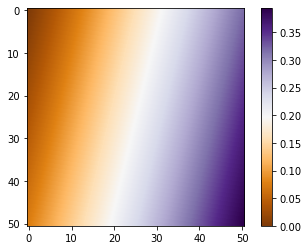

In [16]:
x = y = np.linspace(0, 2, 51)
z = np.array([compute_loss([i, j, 1]) for j in y for i in x])
Z = z.reshape(51, 51)
plt.imshow(Z, interpolation='bilinear', cmap='PuOr')
plt.colorbar()
plt.show()

## Analitycally approach

#### The loss function depends on the integrals $I_i$ and the corresponding weights $w_i$ and is of the form $$\mathcal{L} = \text{Loss}(w_1, \ldots, w_n, I_1, \ldots, I_n) = \sum_1^n w_i \times I_i$$ But $I_i$ does not depend on the weights $w_i$. Therefore, $$\frac{\partial I_i}{\partial w_j} = 0$$ $$\frac{\partial\mathcal{L}}{\partial w_i} = I_i$$ It means that the loss function has no singular points.

# 4: Given data research

In [ ]:
dataset1.show_pm_list()

In [ ]:
a = [(el-0.5).sum() for el in dataset1.pm_list]
a

In [ ]:
with open('./data/sn1996k1904eng.abz') as f:
    lines = [line.rstrip() for line in f]
    my_shape = [int(x) for x in lines[0].split()[-6:-4]]
    my_shape.reverse()
    width, height = my_shape[0], my_shape[1]
    img_array = np.full(shape=my_shape, fill_value=255)
    for line in lines[3:]:
        line = [int(x) for x in line.split()]
        if len(line) == 3:
            y = line[0]
            x1 = line[1]
            x2 = -line[2]
            for i in range(x1, x2 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
        elif len(line) == 5:
            y = line[0]
            x1 = line[1]
            x2 = -line[2]
            x3 = line[3]
            x4 = -line[4]
            for i in range(x1, x2 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
            for i in range(x3, x4 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
        elif len(line) > 6:
            vol_number = line[0]
            plt.imshow(img_array, cmap='gray')
            plt.title(f'{vol_number}')
            plt.show()
            
    
plt.imshow(img_array, cmap='gray')

In [ ]:
out_list = [dataset1.img_array.reshape(-1, 1) / 255]
out_list

# 5: Closed curves

In [11]:
# PLot random gaussian field 2d
from scipy.stats import multivariate_normal
def plot_gaussian_field_2d(mean, cov, n=100):
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    rv = multivariate_normal(mean, cov)
    plt.contourf(X, Y, rv.pdf(pos))
    plt.colorbar()
    plt.show()




In [ ]:
@interact(mean1=(-1, 1, 0.01), mean2=(-1, 1, 0.01), cov11=(0, 1, 0.01), cov12=(-1, 1, 0.01), cov21=(-1, 1, 0.01), cov22=(0, 1, 0.01))
def plot_gaussian_field(mean1=0, mean2=0, cov11=1, cov12=0, cov21=0, cov22=1):
    mean = np.array([mean1, mean2])
    cov = np.array([[cov11, cov12], [cov21, cov22]])
    plot_gaussian_field_2d(mean, cov)
    

In [3]:
# plot random surface in plotly

import plotly.graph_objects as go
import numpy as np
d = np.random.randn(10, 10)


In [7]:
fig = go.Figure(data=[go.Surface(z=d)])
fig.show()

In [19]:
def plot_closed_curve(points_number = 10):
    rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
    phi = 2 * torch.pi * torch.rand(points_number)
    t = torch.linspace(0, 2 * torch.pi, 20)
    r = torch.ones(len(t))
    for h in range(points_number):
        r += rho[h] * torch.sin(h * t + phi[h])
    x, y = r * torch.sin(t), r * torch.cos(t)
    plt.figure(figsize=(18, 9))
    plt.subplot(1, 2, 1)
    plt.plot(t, r, t, r, 'x')
    plt.xlabel('t, radians')
    plt.ylabel('r(t)')
    plt.subplot(1, 2, 2)
    plt.plot(x, y, x, y, 'x')
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')


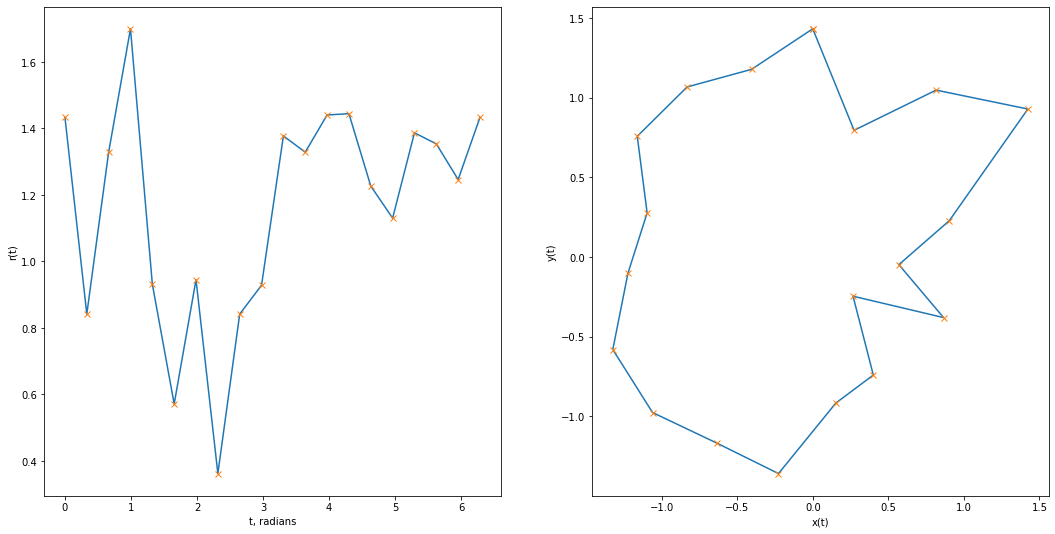

In [20]:
plot_closed_curve(50)

Text(0, 0.5, 'y(t)')

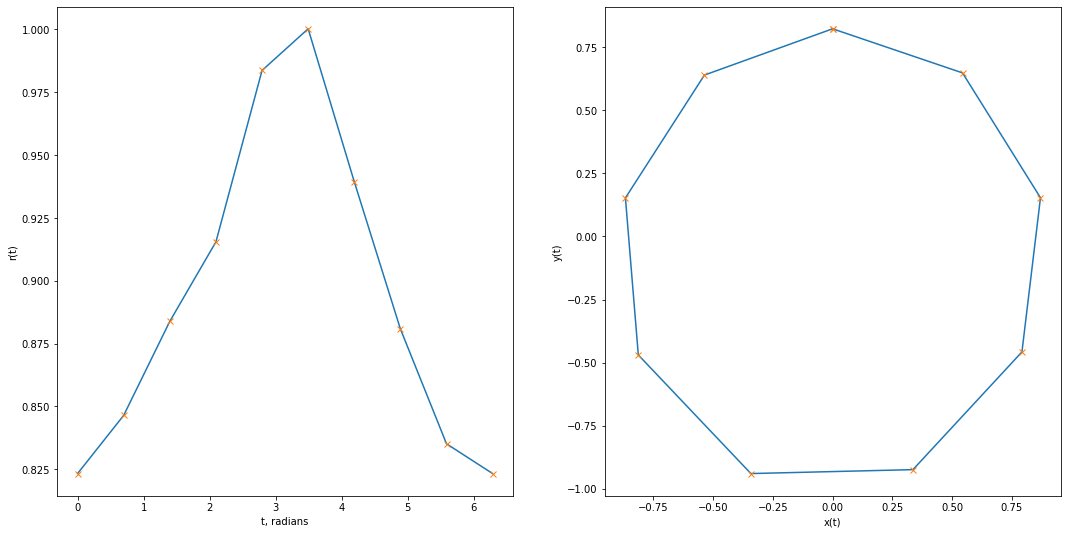

In [21]:
points_number = 5
rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
phi = 2 * torch.pi * torch.rand(points_number)
t = torch.linspace(0, 2 * torch.pi, 10)
r = torch.ones(len(t))
for h in range(points_number):
    r += rho[h] * torch.sin(h * t + phi[h])
x, y = r * torch.sin(t), r * torch.cos(t)
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')

In [22]:
H = 10
rho = np.random.rand(H)*np.logspace(-0.5,-2.5,H)
phi = np.random.rand(H)* 2*np.pi

t = np.linspace(0,2*np.pi,101)
r = np.ones(len(t))
for h in range(H):
    r = r + rho[h]*np.sin(h*t+phi[h])
x = r * np.cos(t)
y = r * np.sin(t)

Text(0, 0.5, 'y(t)')

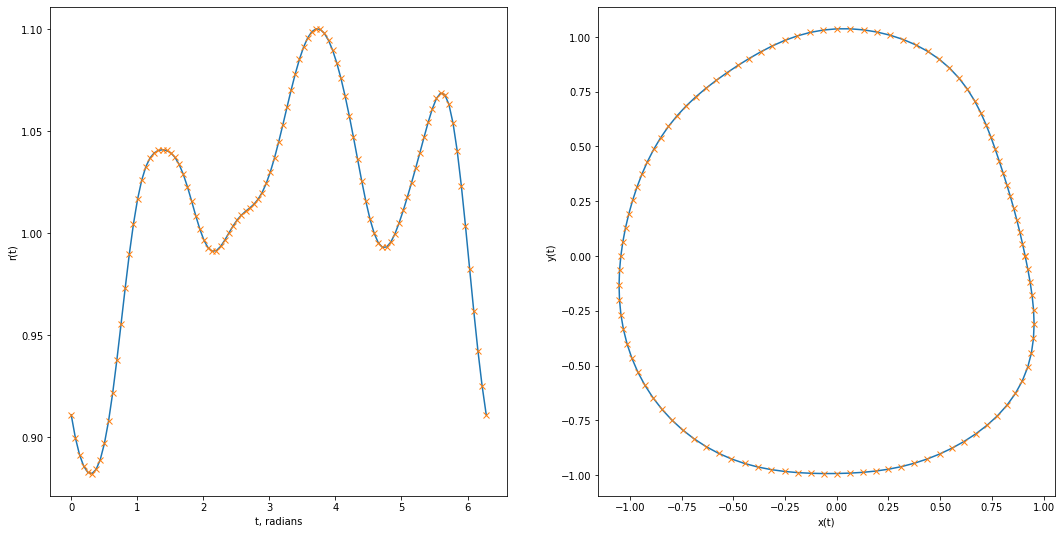

In [23]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')